BMI HW 3

Saumya Diwan

Problem: Model-based Bias Removal in Machine Learning using Synthetic Blood Pressure Data

In [117]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [38]:
#used generative AI to convert table in reference table from the preprint mentioned in the assignmetn
# --- Step 1: Define data ---
data = {
    "Age": ["<20", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "≥90"],
    "Number": [193631, 547023, 674798, 806952, 984094, 1012979, 732165, 305157, 60637],
    "%": [3.6, 10.3, 12.7, 15.2, 18.5, 19.1, 13.8, 5.7, 1.1],
    "mean_SBP": [115.05, 121.27, 123.79, 127.32, 129.98, 132.42, 134.62, 136.89, 138.11],
    "std_SBP": [13.65, 14.19, 15.91, 16.93, 17.19, 17.13, 17.36, 18.35, 19.59],
    "mean_DBP": [69.80, 74.27, 77.31, 79.36, 79.05, 76.71, 74.06, 71.56, 69.86],
    "std_DBP": [8.90, 9.60, 10.48, 10.46, 9.88, 9.38, 9.11, 9.22, 9.44],
    "rho_SBP_DBP": [0.61, 0.66, 0.74, 0.73, 0.67, 0.58, 0.52, 0.49, 0.50]
}

# --- Step 2: Create DataFrame ---
df = pd.DataFrame(data)

# --- Step 3: Compute class marks (midpoint of age ranges) ---
def get_class_mark(age_str):
    if "<" in age_str:
        return 10
    elif "≥" in age_str or ">" in age_str:
        return 95
    else:
        start, end = map(int, age_str.split('-'))
        return (start + end) / 2

df["Age_class_mark"] = df["Age"].apply(get_class_mark)

# --- Step 4: Display the DataFrame ---
print(df)


     Age   Number     %  mean_SBP  std_SBP  mean_DBP  std_DBP  rho_SBP_DBP  \
0    <20   193631   3.6    115.05    13.65     69.80     8.90         0.61   
1  20-29   547023  10.3    121.27    14.19     74.27     9.60         0.66   
2  30-39   674798  12.7    123.79    15.91     77.31    10.48         0.74   
3  40-49   806952  15.2    127.32    16.93     79.36    10.46         0.73   
4  50-59   984094  18.5    129.98    17.19     79.05     9.88         0.67   
5  60-69  1012979  19.1    132.42    17.13     76.71     9.38         0.58   
6  70-79   732165  13.8    134.62    17.36     74.06     9.11         0.52   
7  80-89   305157   5.7    136.89    18.35     71.56     9.22         0.49   
8    ≥90    60637   1.1    138.11    19.59     69.86     9.44         0.50   

   Age_class_mark  
0            10.0  
1            24.5  
2            34.5  
3            44.5  
4            54.5  
5            64.5  
6            74.5  
7            84.5  
8            95.0  


In [39]:
#Polynomial functions from the assignment (a is age in years and ci and di are coefficients)
#SBP(a) = c1a2 + c2a + c3
#DBP(a) = d1a2 + d2a + d3

#A i
def polynomial_sbp_a(a,c1,c2,c3):
  function_sbp= c1*a**2 + c2*a + c3
  return function_sbp

def polynomial_dbp_a(a,d1,d2,d3):
  function_dbp= d1*a**2 + d2*a + d3
  return function_dbp

def sigmoid_sbp_a(a,Smax,k,a0):
  function_sbp_sigmoid= Smax/(1+np.exp(-k*(a-a0)))
  return function_sbp_sigmoid

def gaussian_dbp_a(a,Dmax,apeak,sigma):
  function_dbp_gaussian= Dmax*np.exp(-(a-apeak)**2/(2*sigma**2))
  return function_dbp_gaussian


In [40]:
#model fitting
#A ii
#initial parameter seed points have been generated with generative AI fed with tabular data df
age_array = df["Age_class_mark"].values
sbp_array = df["mean_SBP"].values
dbp_array = df["mean_DBP"].values

coefficients_sbp, covariance_sbp = curve_fit(polynomial_sbp_a,age_array, sbp_array, p0=[-0.002, 0.3, 110])

coefficients_dbp, covariance_dbp = curve_fit(polynomial_dbp_a,age_array, dbp_array, p0=[-0.005, 0.9, 65])

coefficients_sbp_sigmoid, covariance_sbp_sigmoid = curve_fit(sigmoid_sbp_a,age_array, sbp_array,p0=[140, 0.07, 40])

coefficients_dbp_gaussian, covariance_dbp_gaussian = curve_fit(gaussian_dbp_a,age_array, dbp_array,p0=[80, 45, 20])

c1, c2, c3 = coefficients_sbp
d1, d2, d3 = coefficients_dbp
Smax,k,a0 = coefficients_sbp_sigmoid
Dmax,apeak,sigma = coefficients_dbp_gaussian

In [41]:
coefficients_table ={"Coefficients for SBP and DBP" : ["c1","c2","c3","d1", "d2", "d3","Smax","k","a0","Dmax","apeak","sigma"],
                     "Values": [c1,c2,c3,d1,d2,d3,Smax,k,a0,Dmax,apeak,sigma]}

coefficients_df = pd.DataFrame(coefficients_table)
print(coefficients_df)

   Coefficients for SBP and DBP      Values
0                            c1   -0.001532
1                            c2    0.431291
2                            c3  111.083788
3                            d1   -0.004983
4                            d2    0.505025
5                            d3   65.479662
6                          Smax  148.910538
7                             k    0.015761
8                            a0  -67.937007
9                          Dmax   78.372481
10                        apeak   50.569448
11                        sigma   85.573570


In [42]:
#for computing MSE and R^2, we need actual vs predicted points to evaluate the model fitting
#generating predictions
age_points= np.linspace(10,95,500)
predictions_sbp_polynomial = polynomial_sbp_a(age_points,c1,c2,c3)
predictions_dbp_polynomial = polynomial_dbp_a(age_points,d1,d2,d3)
predictions_sbp_sigmoid = sigmoid_sbp_a(age_points,Smax,k,a0)
predictions_dbp_gaussian = gaussian_dbp_a(age_points,Dmax,apeak,sigma)


In [43]:
# A iii
#computing MSE and R^2 for these predictions vs actual
mse_sbp_polynomial = mean_squared_error(sbp_array, polynomial_sbp_a(age_array,c1,c2,c3))
mse_dbp_polynomial = mean_squared_error(dbp_array, polynomial_dbp_a(age_array,d1,d2,d3))
mse_sbp_sigmoid = mean_squared_error(sbp_array, sigmoid_sbp_a(age_array,Smax,k,a0))
mse_dbp_gaussian = mean_squared_error(dbp_array, gaussian_dbp_a(age_array,Dmax,apeak,sigma))

r2_sbp_polynomial = r2_score(sbp_array,  polynomial_sbp_a(age_array,c1,c2,c3))
r2_dbp_polynomial = r2_score(dbp_array, polynomial_dbp_a(age_array,d1,d2,d3))
r2_sbp_sigmoid = r2_score(sbp_array, sigmoid_sbp_a(age_array,Smax,k,a0))
r2_dbp_gaussian = r2_score(dbp_array, gaussian_dbp_a(age_array,Dmax,apeak,sigma))

Results_table = {"Model": ["Polynomial SBP", "Polynomial DBP", "Sigmoid SBP", "Gaussian DBP"],
                 "MSE": [mse_sbp_polynomial, mse_dbp_polynomial, mse_sbp_sigmoid, mse_dbp_gaussian],
                 "R^2": [r2_sbp_polynomial, r2_dbp_polynomial, r2_sbp_sigmoid, r2_dbp_gaussian]}
Results_table_df = pd.DataFrame(Results_table)
print(Results_table_df)

            Model       MSE       R^2
0  Polynomial SBP  0.065030  0.998764
1  Polynomial DBP  0.897586  0.926137
2     Sigmoid SBP  0.065419  0.998757
3    Gaussian DBP  0.800747  0.934106


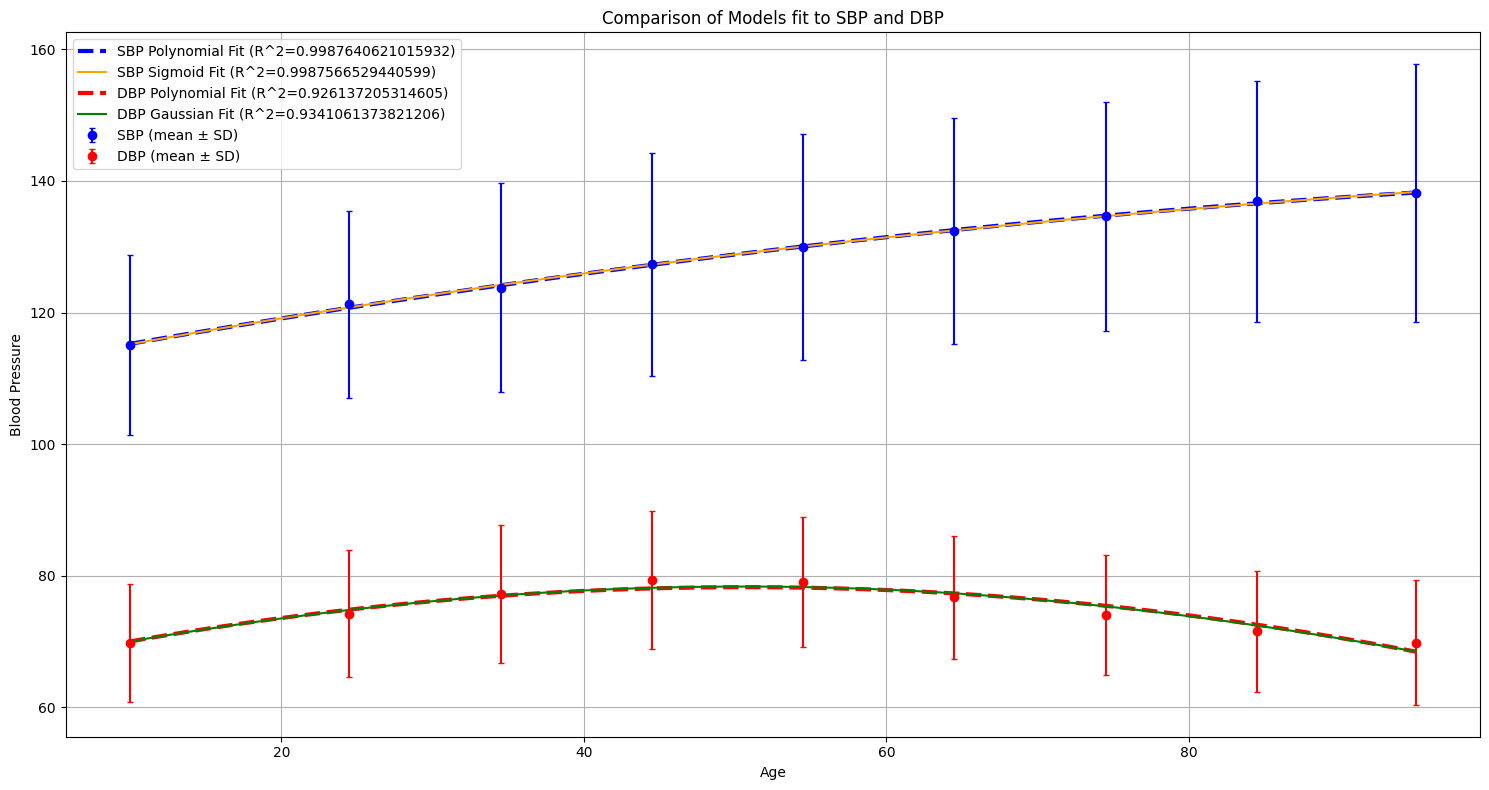

In [74]:
plt.figure(figsize=(15, 8))
#plt.scatter(age_array,sbp_array, label="SBP", color="blue")
#plt.scatter(age_array,dbp_array, label="DBP", color="red")
plt.errorbar(age_array,sbp_array, yerr=df["std_SBP"], label="SBP (mean ± SD)",color="blue",fmt='o',capsize=2)
plt.errorbar(age_array,dbp_array, yerr=df["std_DBP"], label="DBP (mean ± SD)",color="red",fmt='o',capsize=2)
plt.plot(age_points,predictions_sbp_polynomial, label=f"SBP Polynomial Fit (R^2={r2_sbp_polynomial})", color="blue",linestyle='dashed',linewidth=3)
plt.plot(age_points,predictions_sbp_sigmoid, label=f"SBP Sigmoid Fit (R^2={r2_sbp_sigmoid})", color="orange")
plt.plot(age_points,predictions_dbp_polynomial, label=f"DBP Polynomial Fit (R^2={r2_dbp_polynomial})", color="red",linestyle='dashed',linewidth=3)
plt.plot(age_points,predictions_dbp_gaussian, label=f"DBP Gaussian Fit (R^2={r2_dbp_gaussian})", color="green")
plt.title("Comparison of Models fit to SBP and DBP")
plt.xlabel("Age")
plt.ylabel("Blood Pressure")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [ ]:
# B i

In [75]:
#AI generated function below
import numpy as np

# --- Given parameters ---
mean_A = 10.0
std_A  = 2.0
mean_B = 20.0
std_B  = 5.0
rho    = 0.6   # correlation between A and B

n_samples = 1000

# 1. Mean vector
mean = np.array([mean_A, mean_B])

# 2. Covariance matrix
cov_AB = rho * std_A * std_B
cov = np.array([
    [std_A**2,  cov_AB],
    [cov_AB,    std_B**2]
])

# 3. Generate samples from bivariate normal
rng = np.random.default_rng(seed=42)  # optional seed for reproducibility
samples = rng.multivariate_normal(mean, cov, size=n_samples)

# 4. Split back into A and B
A_synth = samples[:, 0]
B_synth = samples[:, 1]

print(A_synth.shape, B_synth.shape)  # (1000,) (1000,)


In [118]:
#adapting this here
sample_size = 100000
N_male=int(sample_size/2)
N_female=int(sample_size/2)


In [119]:
#creating arrays for mean mu and std for male and females separate
mu = [133.0, 78.8, 125.8,74.8]          # [mean SBP male, mean DBP male, mean SBP female,  mean DBP female]
std = [18.6, 12.6, 19.0, 12.4]          # [std SBP male, std DBP male, std SBP female,  std DBP female]
rho = [0.45, 0.5]                         # [correlation male, correaltion female]

#covariance matrices for male and fmale
covariance_matrix_male= [[std[0]**2, rho[0]*std[0]*std[1]],
                        [rho[0]*std[0]*std[1], std[1]**2]]
covariance_matrix_female= [[std[2]**2, rho[1]*std[2]*std[3]],
                        [rho[1]*std[2]*std[3], std[3]**2]]

# synthetic data geeneration using np.random.multivariate_normal
synthetic_male_dataset= np.random.multivariate_normal(mean=mu[:2], cov=covariance_matrix_male, size=N_male)
synthetic_female_dataset= np.random.multivariate_normal(mean=mu[2:], cov=covariance_matrix_female, size=N_female)


In [120]:
dataframe_male=pd.DataFrame(synthetic_male_dataset, columns=["SBP","DBP"])
dataframe_female=pd.DataFrame(synthetic_female_dataset, columns=["SBP","DBP"])
dataframe_male["Sex"]=1
dataframe_female["Sex"]=0

combined_synthetic_dataframe= pd.concat([dataframe_male, dataframe_female], ignore_index=True)
combined_synthetic_dataframe

,SBP,DBP,Sex
0,131.074907,84.388435,1
1,108.562736,59.798718,1
2,122.035122,76.963059,1
3,122.962000,64.968484,1
4,92.288538,43.212406,1
...,...,...,...
99995,122.515979,90.443819,0
99996,101.956961,77.286700,0
99997,115.401375,75.362466,0
99998,120.675791,85.506819,0


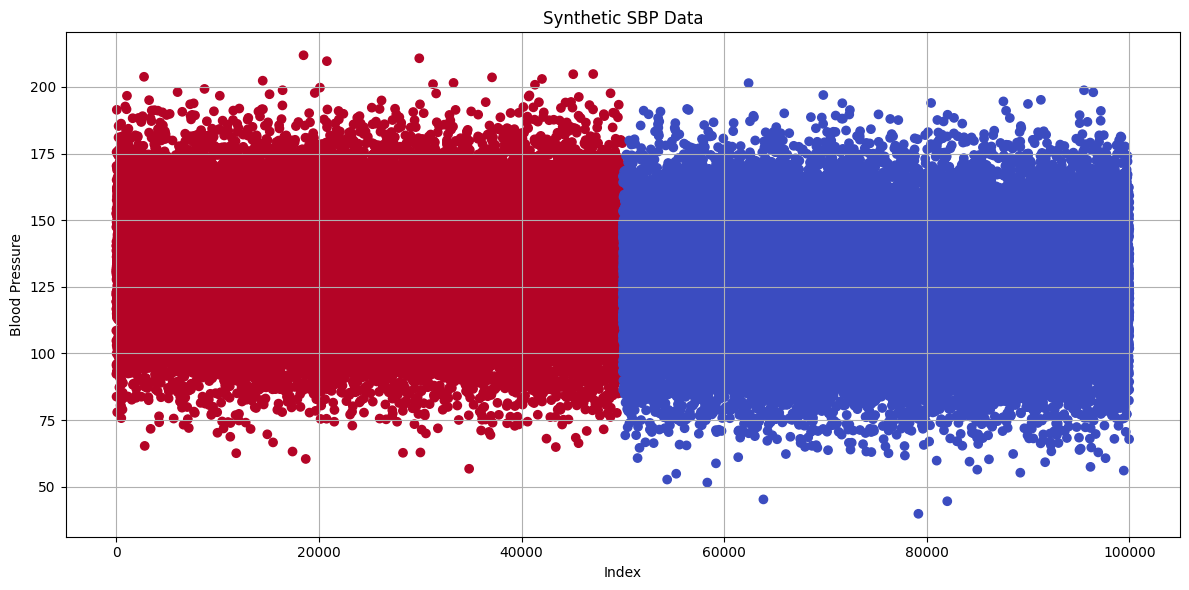

In [121]:
plt.figure(figsize=(12, 6))
plt.scatter(data=combined_synthetic_dataframe, x=combined_synthetic_dataframe.index, y="SBP", c="Sex", cmap="coolwarm")
plt.title("Synthetic SBP Data")
plt.xlabel("Index")
plt.ylabel("Blood Pressure")
plt.grid(True)
plt.tight_layout()
plt.show()


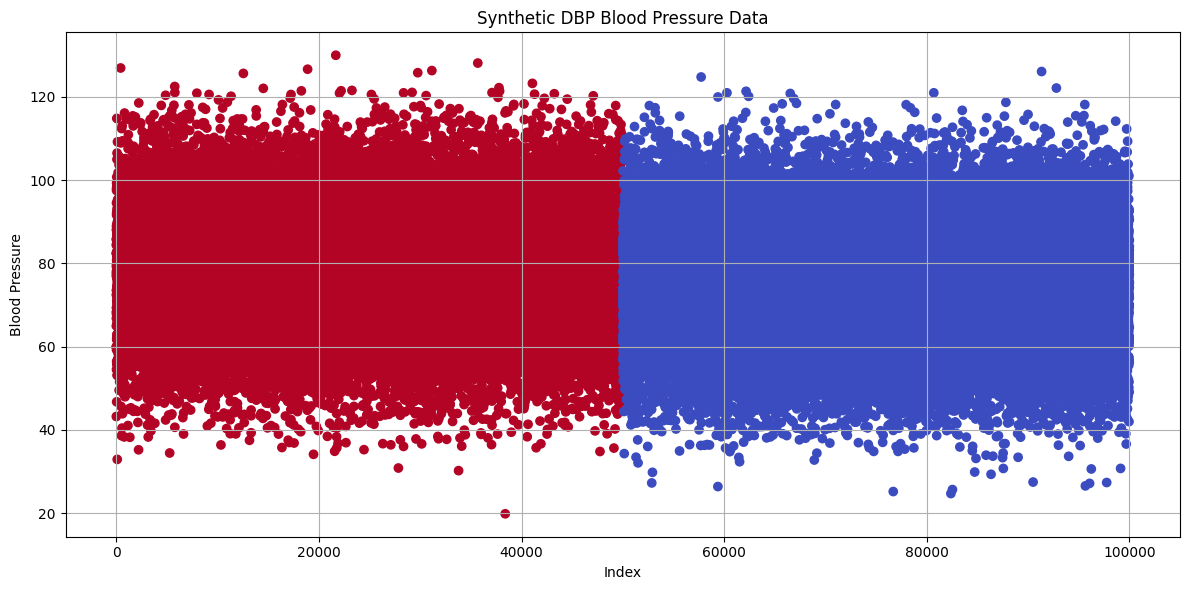

In [122]:
plt.figure(figsize=(12, 6))
plt.scatter(data=combined_synthetic_dataframe, x=combined_synthetic_dataframe.index, y="DBP", c="Sex", cmap="coolwarm")
plt.title("Synthetic DBP Blood Pressure Data")
plt.xlabel("Index")
plt.ylabel("Blood Pressure")
plt.grid(True)
plt.tight_layout()
plt.show()


In [123]:
#shuffling the dataframe indices to see the distribution better
shuffled_combined_synthetic_dataframe = combined_synthetic_dataframe.copy()
shuffled_combined_synthetic_dataframe = shuffled_combined_synthetic_dataframe.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_combined_synthetic_dataframe

,SBP,DBP,Sex
0,114.843780,71.770708,0
1,135.843109,58.605661,0
2,116.627775,92.899733,1
3,113.675533,64.843917,0
4,139.210047,84.013040,0
...,...,...,...
99995,155.533101,98.296559,1
99996,105.278878,76.309544,0
99997,96.821517,74.253627,0
99998,133.802306,96.389032,1


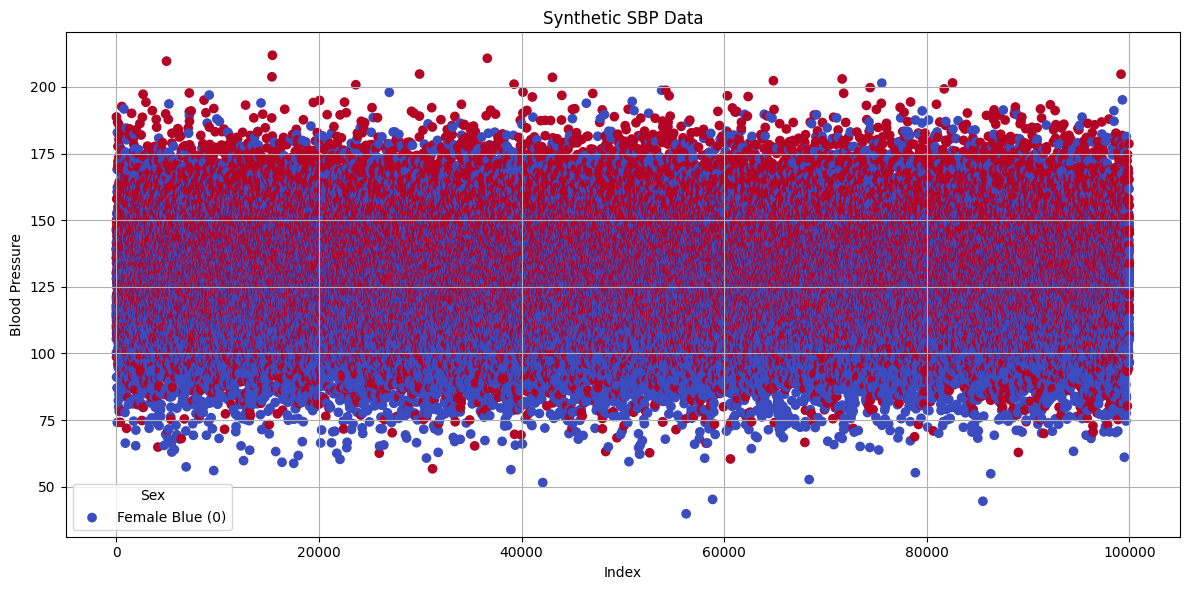

In [124]:
#plotting the synthetic data SBP
plt.figure(figsize=(12, 6))
plt.scatter(data=shuffled_combined_synthetic_dataframe, x=shuffled_combined_synthetic_dataframe.index, y="SBP", c="Sex", cmap="coolwarm")
plt.title("Synthetic SBP Data")
plt.xlabel("Index")
plt.ylabel("Blood Pressure")
plt.legend(title="Sex", labels=["Female Blue (0)"])
plt.grid(True)
plt.tight_layout()
plt.show()


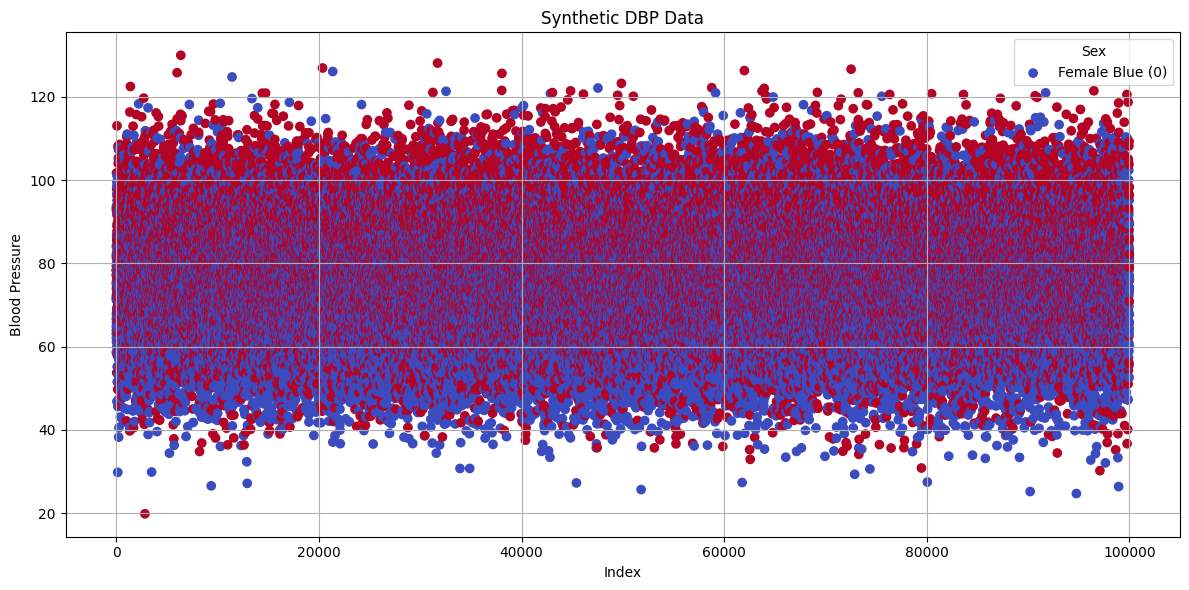

In [125]:
#plotting the synthetic data DBP

plt.figure(figsize=(12, 6))
plt.scatter(data=shuffled_combined_synthetic_dataframe, x=shuffled_combined_synthetic_dataframe.index, y="DBP", c="Sex", cmap="coolwarm")
plt.title("Synthetic DBP Data")
plt.xlabel("Index")
plt.ylabel("Blood Pressure")
plt.legend(title="Sex", labels=["Female Blue (0)"])
plt.grid(True)
plt.tight_layout()
plt.show()


In [126]:
# B ii without stratification
# X is the input data and y is the target
X = shuffled_combined_synthetic_dataframe[["SBP", "DBP"]]
y = shuffled_combined_synthetic_dataframe["Sex"]

#test train split without stratification of y sex
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
#experimenting without stratification on y
model= LogisticRegression()

#model fitting
model.fit(x_train, y_train)

#model predictions
y_pred= model.predict(x_test)
y_prob= model.predict_proba(x_test)[:,1]

#results
accuracy= accuracy_score(y_test, y_pred)
f1= f1_score(y_test, y_pred)
roc_auc= roc_auc_score(y_test, y_prob)
confusion= confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.5842
F1 Score: 0.5833667334669339
ROC AUC: 0.6208176505458592
Confusion Matrix:
[[5862 4216]
 [4100 5822]]


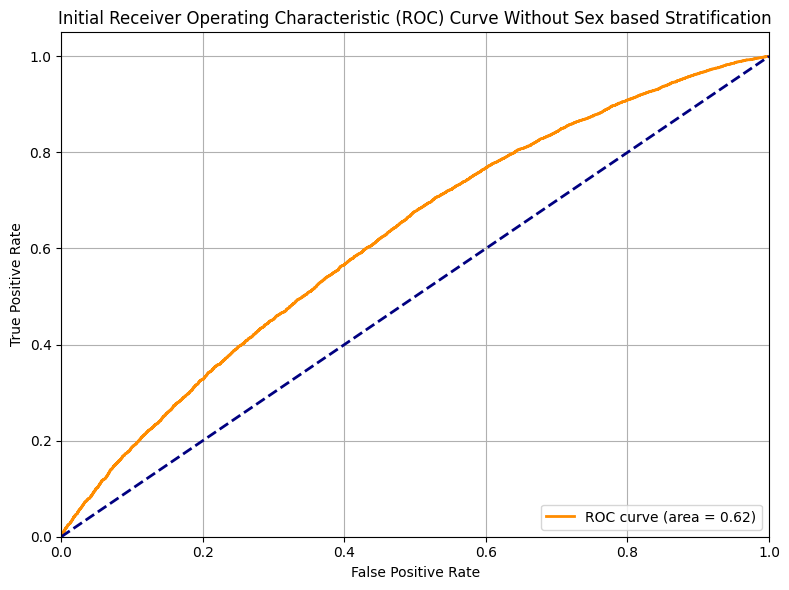

In [128]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Initial Receiver Operating Characteristic (ROC) Curve Without Sex based Stratification')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [129]:
# B ii with stratification
#test train split with stratification of y sex
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [130]:
model= LogisticRegression()

#model fitting
model.fit(x_train, y_train)

#model predictions
y_pred= model.predict(x_test)
y_prob= model.predict_proba(x_test)[:,1]

#results
accuracy= accuracy_score(y_test, y_pred)
f1= f1_score(y_test, y_pred)
roc_auc= roc_auc_score(y_test, y_prob)
confusion= confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.58255
F1 Score: 0.5852252968354116
ROC AUC: 0.61851356
Confusion Matrix:
[[5761 4239]
 [4110 5890]]


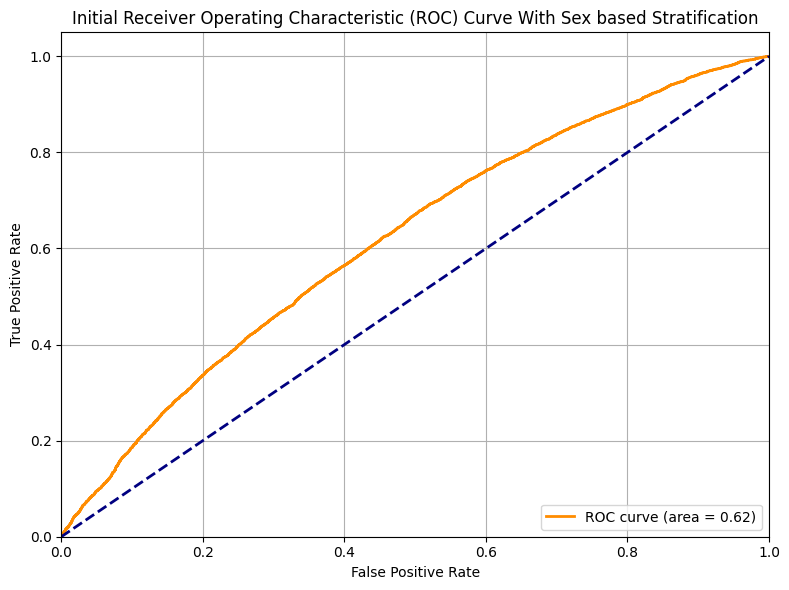

In [131]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Initial Receiver Operating Characteristic (ROC) Curve With Sex based Stratification')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [141]:
#Strategy Im following here is to keep the test set unchanged to prevent data leakge and Im subsampling the train dataset with different ratios M to F.
#Also we used stratification while the initial split the test set is balanced so we can note the change in performance when training set is skewed

train_df = x_train.copy()
train_df["Sex"] = y_train.values
test_df =x_test.copy()
test_df["Sex"]=y_test.values

In [147]:
def subsampling_train_data(df, ratio_MF=0.5, random_state=42):
  male_data=df[df["Sex"] ==1]
  female_data=df[df["Sex"] ==0]
  number_male_samples=int(len(df)*ratio_MF)
  number_female_samples=len(df) -number_male_samples
  #sampling the male and female data
  male_subsample= male_data.sample(n=number_male_samples,replace=True, random_state=random_state)
  female_subsample= female_data.sample(n=number_female_samples,replace=True, random_state=random_state)
  subsampled_df= pd.concat([male_subsample, female_subsample], ignore_index=True)
  #will have to add shuffling of indices here as before
  subsampled_df=subsampled_df.sample(frac=1, random_state=52).reset_index(drop=True)
  return subsampled_df

def model_evaluation_metrics(df_train,df_test):
  X_train = df_train[["SBP", "DBP"]]
  y_train = df_train["Sex"].values.ravel()
  X_test = df_test[["SBP", "DBP"]]
  y_test = df_test["Sex"].values.ravel()
  model = LogisticRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:,1]
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test,y_pred)
  fpr, tpr, thresholds = roc_curve(y_test, y_prob)
  return accuracy, f1, roc_auc, fpr, tpr


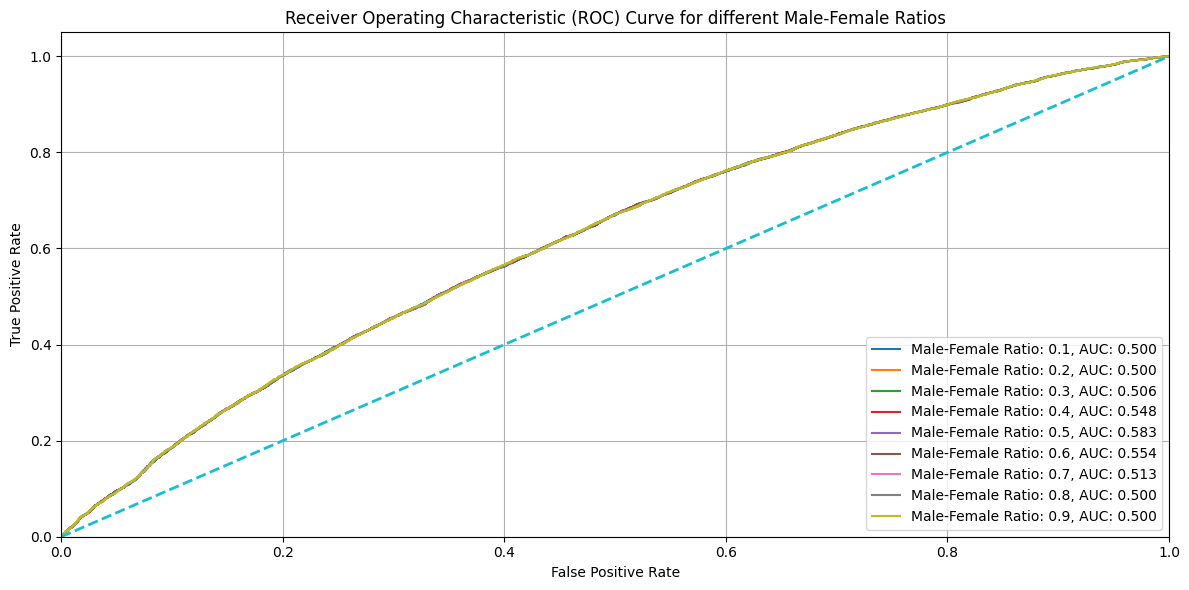

In [149]:
ratios_to_test= [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results=[]

plt.figure(figsize=(12, 6))
for i in ratios_to_test:
  df_ratio_subsampled = subsampling_train_data(train_df, ratio_MF=i)
  accuracy, f1, roc_auc, fpr, tpr = model_evaluation_metrics(df_ratio_subsampled, test_df)
  results.append({"Male-Female Ratio":i,"Accuracy": accuracy, "F1 score": f1,"AUC": roc_auc})
  plt.plot(fpr, tpr, label=f"Male-Female Ratio: {i}, AUC: {roc_auc:.3f}")

plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for different Male-Female Ratios')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [150]:
results

[{'Male-Female Ratio': 0.1,
  'Accuracy': 0.5,
  'F1 score': 0.0,
  'AUC': np.float64(0.5)},
 {'Male-Female Ratio': 0.2,
  'Accuracy': 0.50005,
  'F1 score': 0.00039988003598920324,
  'AUC': np.float64(0.50005)},
 {'Male-Female Ratio': 0.3,
  'Accuracy': 0.50645,
  'F1 score': 0.04766039556198746,
  'AUC': np.float64(0.50645)},
 {'Male-Female Ratio': 0.4,
  'Accuracy': 0.5485,
  'F1 score': 0.31910722364650884,
  'AUC': np.float64(0.5485)},
 {'Male-Female Ratio': 0.5,
  'Accuracy': 0.58275,
  'F1 score': 0.5850116863096126,
  'AUC': np.float64(0.5827499999999999)},
 {'Male-Female Ratio': 0.6,
  'Accuracy': 0.5542,
  'F1 score': 0.6654409005628518,
  'AUC': np.float64(0.5542)},
 {'Male-Female Ratio': 0.7,
  'Accuracy': 0.5131,
  'F1 score': 0.6703676122131204,
  'AUC': np.float64(0.5131)},
 {'Male-Female Ratio': 0.8,
  'Accuracy': 0.50045,
  'F1 score': 0.6668667266846721,
  'AUC': np.float64(0.5004500000000001)},
 {'Male-Female Ratio': 0.9,
  'Accuracy': 0.5,
  'F1 score': 0.6666666666

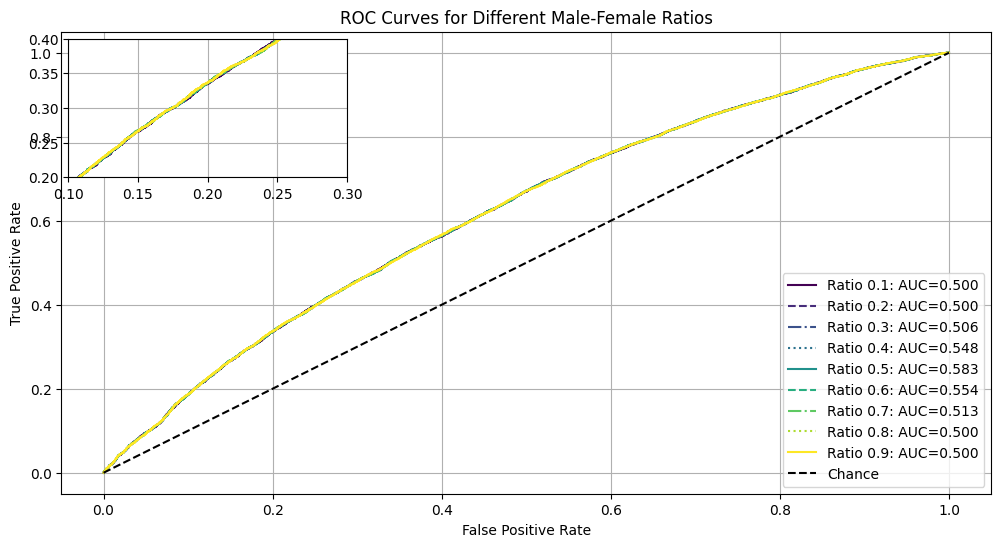

In [152]:
#AI generated code for plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ratios_to_test = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = []

plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(ratios_to_test)))
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-']

for idx, i in enumerate(ratios_to_test):
    df_ratio_subsampled = subsampling_train_data(train_df, ratio_MF=i)
    accuracy, f1, roc_auc, fpr, tpr = model_evaluation_metrics(df_ratio_subsampled, test_df)

    results.append({"Male-Female Ratio":i,
                    "Accuracy": accuracy,
                    "F1 score": f1,
                    "AUC": roc_auc})

    plt.plot(fpr, tpr,
             label=f"Ratio {i}: AUC={roc_auc:.3f}",
             color=colors[idx],
             linestyle=linestyles[idx])

# Diagonal
plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Male-Female Ratios')
plt.legend(loc="lower right")
plt.grid(True)

# OPTIONAL: Zoom-in inset
axins = inset_axes(plt.gca(), width="30%", height="30%", loc="upper left")
for idx, i in enumerate(ratios_to_test):
    df_ratio_subsampled = subsampling_train_data(train_df, ratio_MF=i)
    _, _, roc_auc, fpr, tpr = model_evaluation_metrics(df_ratio_subsampled, test_df)
    axins.plot(fpr, tpr, color=colors[idx], linestyle=linestyles[idx])

axins.set_xlim(0.1, 0.3)
axins.set_ylim(0.2, 0.4)
axins.grid(True)

plt.show()


In [153]:
results_df = pd.DataFrame(results)
print(results_df.to_markdown(index=False))


|   Male-Female Ratio |   Accuracy |   F1 score |     AUC |
|--------------------:|-----------:|-----------:|--------:|
|                 0.1 |    0.5     | 0          | 0.5     |
|                 0.2 |    0.50005 | 0.00039988 | 0.50005 |
|                 0.3 |    0.50645 | 0.0476604  | 0.50645 |
|                 0.4 |    0.5485  | 0.319107   | 0.5485  |
|                 0.5 |    0.58275 | 0.585012   | 0.58275 |
|                 0.6 |    0.5542  | 0.665441   | 0.5542  |
|                 0.7 |    0.5131  | 0.670368   | 0.5131  |
|                 0.8 |    0.50045 | 0.666867   | 0.50045 |
|                 0.9 |    0.5     | 0.666667   | 0.5     |


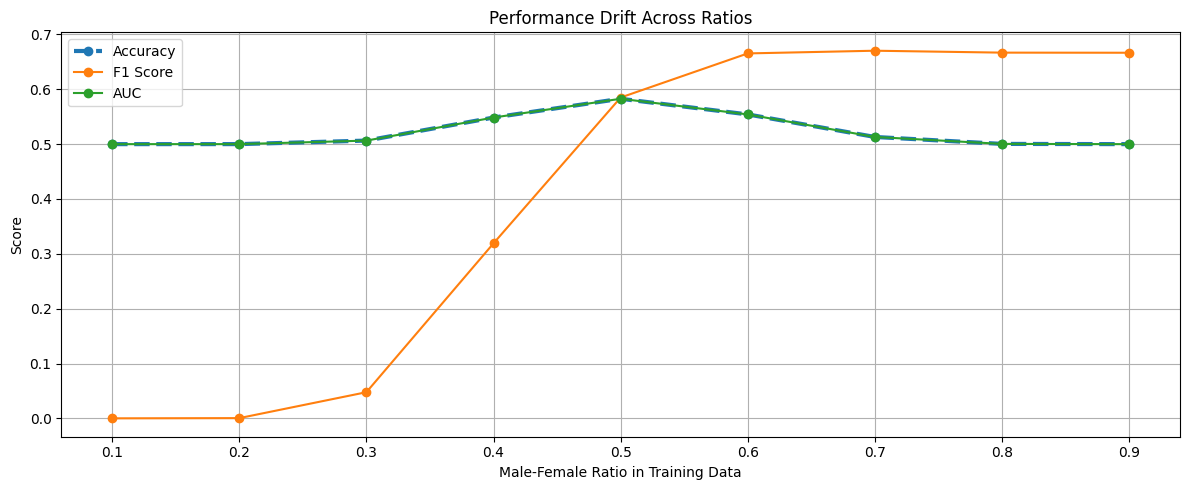

In [159]:
#AI generated code for plotting
plt.figure(figsize=(12,5))

plt.plot(results_df["Male-Female Ratio"], results_df["Accuracy"], marker='o', label="Accuracy", linestyle="dashed",lw=3)
plt.plot(results_df["Male-Female Ratio"], results_df["F1 score"], marker='o', label="F1 Score")
plt.plot(results_df["Male-Female Ratio"], results_df["AUC"], marker='o', label="AUC")

plt.xlabel("Male-Female Ratio in Training Data")
plt.ylabel("Score")
plt.title("Performance Drift Across Ratios")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [160]:
#B iv
#added bias mitigation by using balanced class weight while training
def model_evaluation_metrics_bias_mitigation(df_train,df_test):
  X_train = df_train[["SBP", "DBP"]]
  y_train = df_train["Sex"].values.ravel()
  X_test = df_test[["SBP", "DBP"]]
  y_test = df_test["Sex"].values.ravel()
  model = LogisticRegression(class_weight='balanced')
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:,1]
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test,y_pred)
  fpr, tpr, thresholds = roc_curve(y_test, y_prob)
  return accuracy, f1, roc_auc, fpr, tpr

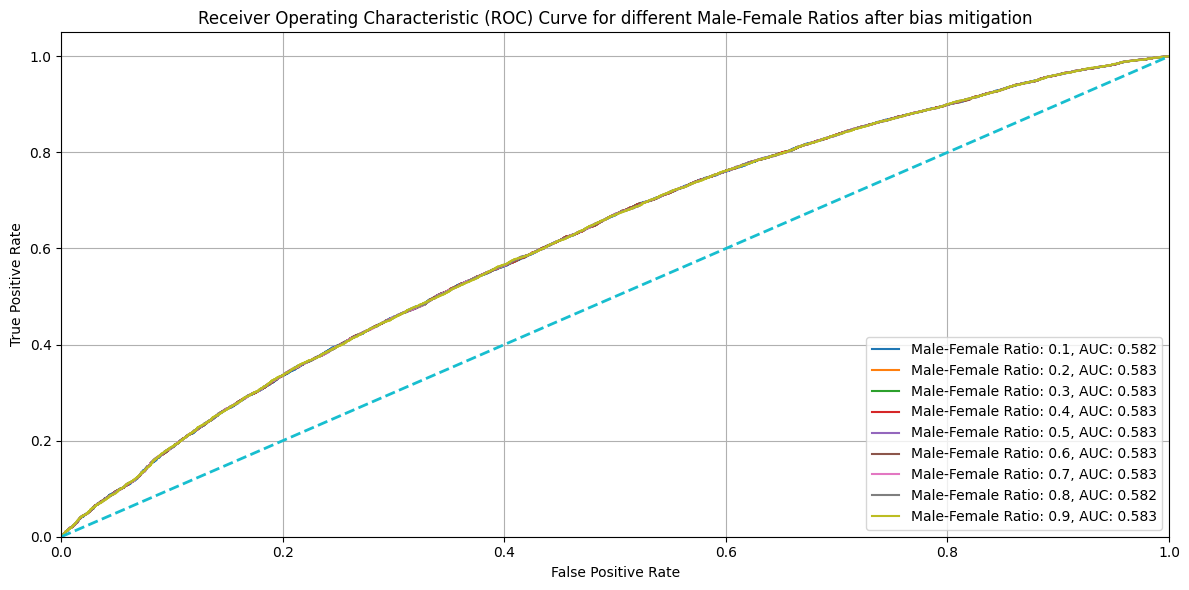

In [170]:
ratios_to_test= [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results=[]

plt.figure(figsize=(12, 6))
for i in ratios_to_test:
  df_ratio_subsampled = subsampling_train_data(train_df, ratio_MF=i)
  accuracy, f1, roc_auc, fpr, tpr = model_evaluation_metrics_bias_mitigation(df_ratio_subsampled, test_df)
  results.append({"Male-Female Ratio":i,"Accuracy": accuracy, "F1 score": f1,"AUC": roc_auc})
  plt.plot(fpr, tpr, label=f"Male-Female Ratio: {i}, AUC: {roc_auc:.3f}")

plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for different Male-Female Ratios after bias mitigation')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [167]:
results

[{'Male-Female Ratio': 0.1,
  'Accuracy': 0.582,
  'F1 score': 0.5836653386454184,
  'AUC': np.float64(0.5820000000000001)},
 {'Male-Female Ratio': 0.2,
  'Accuracy': 0.5827,
  'F1 score': 0.5856830818109611,
  'AUC': np.float64(0.5827)},
 {'Male-Female Ratio': 0.3,
  'Accuracy': 0.58255,
  'F1 score': 0.5851016250062118,
  'AUC': np.float64(0.58255)},
 {'Male-Female Ratio': 0.4,
  'Accuracy': 0.58255,
  'F1 score': 0.5847714726214751,
  'AUC': np.float64(0.5825499999999999)},
 {'Male-Female Ratio': 0.5,
  'Accuracy': 0.58275,
  'F1 score': 0.5850116863096126,
  'AUC': np.float64(0.5827499999999999)},
 {'Male-Female Ratio': 0.6,
  'Accuracy': 0.58265,
  'F1 score': 0.5849122283554627,
  'AUC': np.float64(0.5826499999999999)},
 {'Male-Female Ratio': 0.7,
  'Accuracy': 0.5828,
  'F1 score': 0.585329490110327,
  'AUC': np.float64(0.5828)},
 {'Male-Female Ratio': 0.8,
  'Accuracy': 0.58215,
  'F1 score': 0.5850340136054422,
  'AUC': np.float64(0.58215)},
 {'Male-Female Ratio': 0.9,
  'Accu

In [168]:
results_df = pd.DataFrame(results)
print(results_df.to_markdown(index=False))


|   Male-Female Ratio |   Accuracy |   F1 score |     AUC |
|--------------------:|-----------:|-----------:|--------:|
|                 0.1 |    0.582   |   0.583665 | 0.582   |
|                 0.2 |    0.5827  |   0.585683 | 0.5827  |
|                 0.3 |    0.58255 |   0.585102 | 0.58255 |
|                 0.4 |    0.58255 |   0.584771 | 0.58255 |
|                 0.5 |    0.58275 |   0.585012 | 0.58275 |
|                 0.6 |    0.58265 |   0.584912 | 0.58265 |
|                 0.7 |    0.5828  |   0.585329 | 0.5828  |
|                 0.8 |    0.58215 |   0.585034 | 0.58215 |
|                 0.9 |    0.58255 |   0.584854 | 0.58255 |


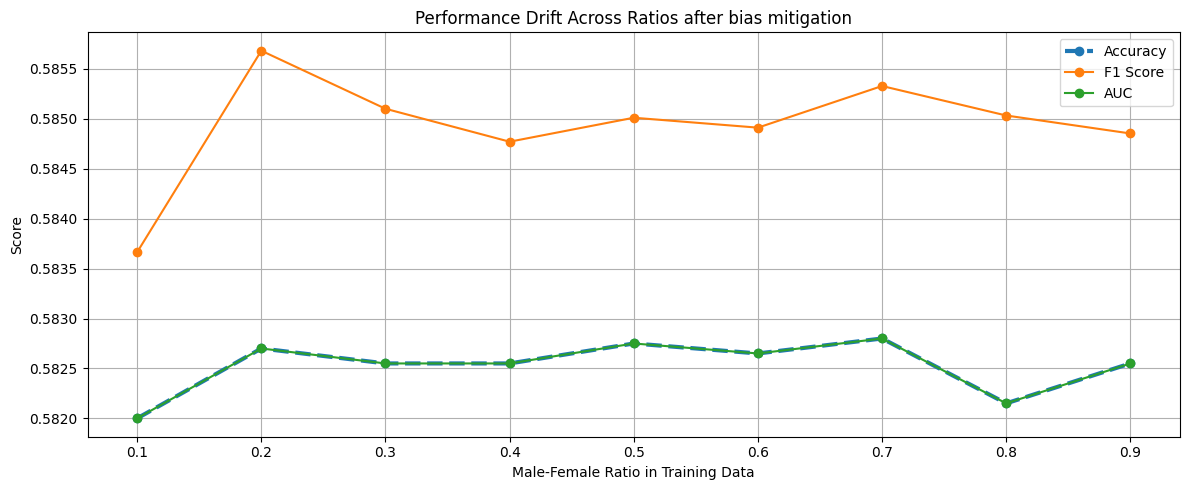

In [171]:
#AI generated code for plotting
plt.figure(figsize=(12,5))

plt.plot(results_df["Male-Female Ratio"], results_df["Accuracy"], marker='o', label="Accuracy", linestyle="dashed",lw=3)
plt.plot(results_df["Male-Female Ratio"], results_df["F1 score"], marker='o', label="F1 Score")
plt.plot(results_df["Male-Female Ratio"], results_df["AUC"], marker='o', label="AUC")

plt.xlabel("Male-Female Ratio in Training Data")
plt.ylabel("Score")
plt.title("Performance Drift Across Ratios after bias mitigation")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
